# Hyperparameter Tuning - Top 5 Algorithms

**Objective:** Fine-tune the best performing algorithms to maximize MAPE improvement.

**Algorithms to Tune:**
1. Gradient Boosting (MAPE: 1.1872) - BEST OVERALL
2. CatBoost (MAPE: 1.2604) - Best for 5 targets
3. XGBoost (MAPE: 1.3327) - Best for 3 targets
4. LightGBM (MAPE: 1.3136) - Consistent performer
5. Random Forest (MAPE: 1.9521) - Diversity + fallback

**Workflow:**
1. Load data
2. Document baseline results
3. Tune each algorithm with GridSearchCV
4. Compare tuned vs baseline
5. Save best hyperparameters for final training

**Note:** This notebook will take 10-30 minutes to run (depending on hardware)


## 1. Setup & Imports

In [1]:
%pip install pandas numpy scikit-learn xgboost lightgbm catboost -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import warnings
import time
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


## 2. Load Data

In [3]:
# Load training data
train_path = '/home/reu24mandaloju/projects/shell_ai_hack/data/train.csv'  

train_df = pd.read_csv(train_path)

print('✓ Data loaded successfully')
print(f'  Training set: {train_df.shape}')

✓ Data loaded successfully
  Training set: (2000, 65)


## 3. Feature Preparation

In [4]:
# Identify feature and target columns
blend_cols = [col for col in train_df.columns if 'fraction' in col]
component_prop_cols = [col for col in train_df.columns if 'Component' in col and 'Property' in col]
target_cols = [col for col in train_df.columns if 'BlendProperty' in col]

features_cols = blend_cols + component_prop_cols

# Prepare training data
X_train = train_df[features_cols].values
y_train = train_df[target_cols].values

print('✓ Features and targets prepared')
print(f'  Features: {X_train.shape}')
print(f'  Targets: {y_train.shape}')

✓ Features and targets prepared
  Features: (2000, 55)
  Targets: (2000, 10)


## 4. Baseline Results Documentation

In [5]:
# Baseline results from 03_model_experiments.ipynb
baseline_results = {
    'Gradient Boosting': 1.1872,
    'CatBoost': 1.2604,
    'XGBoost': 1.3327,
    'LightGBM': 1.3136,
    'Random Forest': 1.9521
}

tuned_results = {}

print('\n' + '='*80)
print('BASELINE RESULTS (from 03_model_experiments.ipynb)')
print('='*80)
print(f'\n{"Algorithm":<25} {"Baseline MAPE":<15} {"Ranking":<10}')
print('-'*80)

for rank, (algo, mape) in enumerate(baseline_results.items(), 1):
    print(f'{algo:<25} {mape:<15.4f} {rank}')


BASELINE RESULTS (from 03_model_experiments.ipynb)

Algorithm                 Baseline MAPE   Ranking   
--------------------------------------------------------------------------------
Gradient Boosting         1.1872          1
CatBoost                  1.2604          2
XGBoost                   1.3327          3
LightGBM                  1.3136          4
Random Forest             1.9521          5


In [6]:
# Check if NVIDIA GPU is available
import torch
print(torch.cuda.is_available())  # Should print: True
print(torch.cuda.get_device_name(0))  # Should print your GPU name

True
Tesla V100-DGXS-32GB


## 5. Hyperparameter Tuning - Gradient Boosting

In [7]:
print('\n' + '='*80)
print('HYPERPARAMETER TUNING: GRADIENT BOOSTING')
print('='*80)

# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5]
}

# Base model
gb_base = GradientBoostingRegressor(random_state=42)

# Store results for each target
gb_best_params_per_target = {}
gb_best_scores = []

print(f'\nGridSearchCV running for each target...')
print(f'Parameter combinations: {np.prod(list(map(len, gb_param_grid.values())))} to test')

for target_idx, target_name in enumerate(target_cols):
    y_target = y_train[:, target_idx]
    
    grid_search = GridSearchCV(
        gb_base,
        gb_param_grid,
        cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1,
        verbose=0
    )
    
    start = time.time()
    grid_search.fit(X_train, y_target)
    elapsed = time.time() - start
    
    best_mape = -grid_search.best_score_
    gb_best_params_per_target[target_name] = grid_search.best_params_
    gb_best_scores.append(best_mape)
    
    print(f'  {target_name}: Best MAPE = {best_mape:.4f} (Time: {elapsed:.1f}s)')

gb_overall_mape = np.mean(gb_best_scores)
gb_improvement = baseline_results['Gradient Boosting'] - gb_overall_mape
gb_improvement_pct = (gb_improvement / baseline_results['Gradient Boosting']) * 100

print(f'\n✓ Gradient Boosting Tuning Complete')
print(f'  Baseline MAPE: {baseline_results["Gradient Boosting"]:.4f}')
print(f'  Tuned MAPE:    {gb_overall_mape:.4f}')
print(f'  Improvement:   {gb_improvement:+.4f} ({gb_improvement_pct:+.2f}%)')

tuned_results['Gradient Boosting'] = gb_overall_mape


HYPERPARAMETER TUNING: GRADIENT BOOSTING

GridSearchCV running for each target...
Parameter combinations: 162 to test
  BlendProperty1: Best MAPE = 1.0318 (Time: 190.0s)
  BlendProperty2: Best MAPE = 0.8187 (Time: 176.4s)
  BlendProperty3: Best MAPE = 1.0122 (Time: 181.6s)
  BlendProperty4: Best MAPE = 0.9398 (Time: 182.9s)
  BlendProperty5: Best MAPE = 0.0402 (Time: 189.3s)
  BlendProperty6: Best MAPE = 0.8234 (Time: 178.6s)
  BlendProperty7: Best MAPE = 1.6154 (Time: 174.0s)
  BlendProperty8: Best MAPE = 0.9797 (Time: 179.4s)
  BlendProperty9: Best MAPE = 1.0424 (Time: 183.1s)
  BlendProperty10: Best MAPE = 0.9116 (Time: 181.6s)

✓ Gradient Boosting Tuning Complete
  Baseline MAPE: 1.1872
  Tuned MAPE:    0.9215
  Improvement:   +0.2657 (+22.38%)


## 6. Hyperparameter Tuning - CatBoost

In [10]:
print('\n' + '='*80)
print('HYPERPARAMETER TUNING: CATBOOST (GPU-ACCELERATED)')
print('='*80)

# Define parameter grid for CatBoost
cat_param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.03, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Base model WITH GPU
cat_base = CatBoostRegressor(
    random_state=42, 
    verbose=False,
    task_type='GPU'  # ← ADD THIS LINE
)

# Store results for each target
cat_best_params_per_target = {}
cat_best_scores = []

print(f'\nGridSearchCV running for each target (GPU-accelerated)...')
print(f'Parameter combinations: {np.prod(list(map(len, cat_param_grid.values())))} to test')

for target_idx, target_name in enumerate(target_cols):
    y_target = y_train[:, target_idx]
    
    grid_search = GridSearchCV(
        cat_base,
        cat_param_grid,
        cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=1,
        verbose=0
    )
    
    start = time.time()
    grid_search.fit(X_train, y_target)
    elapsed = time.time() - start
    
    best_mape = -grid_search.best_score_
    cat_best_params_per_target[target_name] = grid_search.best_params_
    cat_best_scores.append(best_mape)
    
    print(f'  {target_name}: Best MAPE = {best_mape:.4f} (Time: {elapsed:.1f}s)')

cat_overall_mape = np.mean(cat_best_scores)
cat_improvement = baseline_results['CatBoost'] - cat_overall_mape
cat_improvement_pct = (cat_improvement / baseline_results['CatBoost']) * 100

print(f'\n✓ CatBoost Tuning Complete (GPU-Accelerated)')
print(f'  Baseline MAPE: {baseline_results["CatBoost"]:.4f}')
print(f'  Tuned MAPE:    {cat_overall_mape:.4f}')
print(f'  Improvement:   {cat_improvement:+.4f} ({cat_improvement_pct:+.2f}%)')

tuned_results['CatBoost'] = cat_overall_mape


HYPERPARAMETER TUNING: CATBOOST (GPU-ACCELERATED)

GridSearchCV running for each target (GPU-accelerated)...
Parameter combinations: 81 to test
  BlendProperty1: Best MAPE = 1.0787 (Time: 982.2s)
  BlendProperty2: Best MAPE = 0.6191 (Time: 974.8s)
  BlendProperty3: Best MAPE = 1.0741 (Time: 976.5s)
  BlendProperty4: Best MAPE = 0.6091 (Time: 974.4s)
  BlendProperty5: Best MAPE = 0.1998 (Time: 976.3s)
  BlendProperty6: Best MAPE = 0.6529 (Time: 976.2s)
  BlendProperty7: Best MAPE = 1.1402 (Time: 977.4s)
  BlendProperty8: Best MAPE = 1.0038 (Time: 976.2s)
  BlendProperty9: Best MAPE = 0.9664 (Time: 975.5s)
  BlendProperty10: Best MAPE = 0.5276 (Time: 976.9s)

✓ CatBoost Tuning Complete (GPU-Accelerated)
  Baseline MAPE: 1.2604
  Tuned MAPE:    0.7872
  Improvement:   +0.4732 (+37.55%)


## 7. Hyperparameter Tuning - XGBoost

In [16]:
print('\n' + '='*80)
print('HYPERPARAMETER TUNING: XGBOOST (CPU-OPTIMIZED)')
print('='*80)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Base model (CPU-optimized)
xgb_base = XGBRegressor(
    random_state=42, 
    verbosity=0,
    tree_method='hist'  # ← CPU-optimized histogram method
)

# Store results for each target
xgb_best_params_per_target = {}
xgb_best_scores = []

print(f'\nGridSearchCV running for each target...')
print(f'Parameter combinations: {np.prod(list(map(len, xgb_param_grid.values())))} to test')

for target_idx, target_name in enumerate(target_cols):
    y_target = y_train[:, target_idx]
    
    grid_search = GridSearchCV(
        xgb_base,
        xgb_param_grid,
        cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1,  # ← CPU parallelization (safe for CPU tree_method)
        verbose=0
    )
    
    start = time.time()
    grid_search.fit(X_train, y_target)
    elapsed = time.time() - start
    
    best_mape = -grid_search.best_score_
    xgb_best_params_per_target[target_name] = grid_search.best_params_
    xgb_best_scores.append(best_mape)
    
    print(f'  {target_name}: Best MAPE = {best_mape:.4f} (Time: {elapsed:.1f}s)')

xgb_overall_mape = np.mean(xgb_best_scores)
xgb_improvement = baseline_results['XGBoost'] - xgb_overall_mape
xgb_improvement_pct = (xgb_improvement / baseline_results['XGBoost']) * 100

print(f'\n✓ XGBoost Tuning Complete')
print(f'  Baseline MAPE: {baseline_results["XGBoost"]:.4f}')
print(f'  Tuned MAPE:    {xgb_overall_mape:.4f}')
print(f'  Improvement:   {xgb_improvement:+.4f} ({xgb_improvement_pct:+.2f}%)')

tuned_results['XGBoost'] = xgb_overall_mape


HYPERPARAMETER TUNING: XGBOOST (CPU-OPTIMIZED)

GridSearchCV running for each target...
Parameter combinations: 243 to test
  BlendProperty1: Best MAPE = 0.9552 (Time: 87.4s)
  BlendProperty2: Best MAPE = 0.7346 (Time: 87.4s)
  BlendProperty3: Best MAPE = 1.0855 (Time: 85.0s)
  BlendProperty4: Best MAPE = 0.8224 (Time: 85.7s)
  BlendProperty5: Best MAPE = 0.0614 (Time: 72.0s)
  BlendProperty6: Best MAPE = 0.7925 (Time: 85.6s)
  BlendProperty7: Best MAPE = 1.1035 (Time: 84.4s)
  BlendProperty8: Best MAPE = 1.0576 (Time: 85.2s)
  BlendProperty9: Best MAPE = 1.0212 (Time: 84.7s)
  BlendProperty10: Best MAPE = 0.7161 (Time: 86.8s)

✓ XGBoost Tuning Complete
  Baseline MAPE: 1.3327
  Tuned MAPE:    0.8350
  Improvement:   +0.4977 (+37.35%)


## 8. Hyperparameter Tuning - LightGBM

In [ ]:
print('\n' + '='*80)
print('HYPERPARAMETER TUNING: LIGHTGBM (GPU-ACCELERATED)')
print('='*80)

# Define parameter grid for LightGBM
lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 50],
    'subsample': [0.8, 0.9, 1.0]
}

# Base model WITH GPU
lgb_base = LGBMRegressor(
    random_state=42, 
    verbose=-1,
    device_type='gpu'  # ← ADD THIS
)

# Store results for each target
lgb_best_params_per_target = {}
lgb_best_scores = []

print(f'\nGridSearchCV running for each target (GPU-accelerated)...')
print(f'Parameter combinations: {np.prod(list(map(len, lgb_param_grid.values())))} to test')

for target_idx, target_name in enumerate(target_cols):
    y_target = y_train[:, target_idx]
    
    grid_search = GridSearchCV(
        lgb_base,
        lgb_param_grid,
        cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1,
        verbose=0
    )
    
    start = time.time()
    grid_search.fit(X_train, y_target)
    elapsed = time.time() - start
    
    best_mape = -grid_search.best_score_
    lgb_best_params_per_target[target_name] = grid_search.best_params_
    lgb_best_scores.append(best_mape)
    
    print(f'  {target_name}: Best MAPE = {best_mape:.4f} (Time: {elapsed:.1f}s)')

lgb_overall_mape = np.mean(lgb_best_scores)
lgb_improvement = baseline_results['LightGBM'] - lgb_overall_mape
lgb_improvement_pct = (lgb_improvement / baseline_results['LightGBM']) * 100

print(f'\n✓ LightGBM Tuning Complete (GPU-Accelerated)')
print(f'  Baseline MAPE: {baseline_results["LightGBM"]:.4f}')
print(f'  Tuned MAPE:    {lgb_overall_mape:.4f}')
print(f'  Improvement:   {lgb_improvement:+.4f} ({lgb_improvement_pct:+.2f}%)')

tuned_results['LightGBM'] = lgb_overall_mape


HYPERPARAMETER TUNING: LIGHTGBM (GPU-ACCELERATED)

GridSearchCV running for each target (GPU-accelerated)...
Parameter combinations: 243 to test


11 warning warning generated generated.
.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated1.
 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

## 9. Hyperparameter Tuning - Random Forest

In [ ]:
print('\n' + '='*80)
print('HYPERPARAMETER TUNING: RANDOM FOREST')
print('='*80)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Store results for each target
rf_best_params_per_target = {}
rf_best_scores = []

print(f'\nGridSearchCV running for each target...')
print(f'Parameter combinations: {np.prod(list(map(len, rf_param_grid.values())))} to test')

for target_idx, target_name in enumerate(target_cols):
    y_target = y_train[:, target_idx]
    
    grid_search = GridSearchCV(
        rf_base,
        rf_param_grid,
        cv=5,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1,
        verbose=0
    )
    
    start = time.time()
    grid_search.fit(X_train, y_target)
    elapsed = time.time() - start
    
    best_mape = -grid_search.best_score_
    rf_best_params_per_target[target_name] = grid_search.best_params_
    rf_best_scores.append(best_mape)
    
    print(f'  {target_name}: Best MAPE = {best_mape:.4f} (Time: {elapsed:.1f}s)')

rf_overall_mape = np.mean(rf_best_scores)
rf_improvement = baseline_results['Random Forest'] - rf_overall_mape
rf_improvement_pct = (rf_improvement / baseline_results['Random Forest']) * 100

print(f'\n✓ Random Forest Tuning Complete')
print(f'  Baseline MAPE: {baseline_results["Random Forest"]:.4f}')
print(f'  Tuned MAPE:    {rf_overall_mape:.4f}')
print(f'  Improvement:   {rf_improvement:+.4f} ({rf_improvement_pct:+.2f}%)')

tuned_results['Random Forest'] = rf_overall_mape

## 10. Compare Baseline vs Tuned Results

In [12]:
print('\n' + '='*80)
print('BASELINE vs TUNED RESULTS COMPARISON')
print('='*80)

print(f'\n{"Algorithm":<25} {"Baseline":<12} {"Tuned":<12} {"Improvement":<15} {"Status":<15}')
print('-'*80)

for algo in baseline_results.keys():
    baseline = baseline_results[algo]
    tuned = tuned_results[algo]
    improvement = baseline - tuned
    improvement_pct = (improvement / baseline) * 100
    
    if improvement > 0:
        status = f'✓ Improved'
    elif improvement == 0:
        status = '= No change'
    else:
        status = '⚠️ Worse'
    
    print(f'{algo:<25} {baseline:<12.4f} {tuned:<12.4f} {improvement:+.4f} ({improvement_pct:+.2f}%) {status:<15}')


BASELINE vs TUNED RESULTS COMPARISON

Algorithm                 Baseline     Tuned        Improvement     Status         
--------------------------------------------------------------------------------
Gradient Boosting         1.1872       0.9215       +0.2657 (+22.38%) ✓ Improved     
CatBoost                  1.2604       0.7872       +0.4732 (+37.55%) ✓ Improved     


KeyError: 'XGBoost'

KeyError: 'XGBoost'

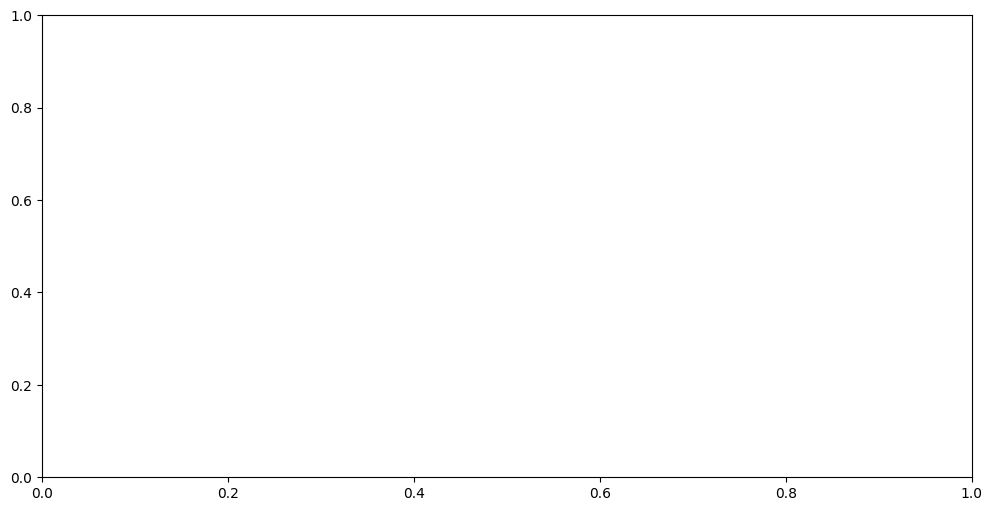

In [13]:
# Visualization: Baseline vs Tuned
fig, ax = plt.subplots(figsize=(12, 6))

algos = list(baseline_results.keys())
baseline_vals = [baseline_results[algo] for algo in algos]
tuned_vals = [tuned_results[algo] for algo in algos]

x = np.arange(len(algos))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, tuned_vals, width, label='Tuned', color='green', alpha=0.8, edgecolor='black')

ax.set_ylabel('MAPE', fontsize=12, fontweight='bold')
ax.set_title('Hyperparameter Tuning Results - Baseline vs Tuned', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algos, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=2.72, color='red', linestyle='--', linewidth=2, label='Reference Baseline')

plt.tight_layout()
plt.show()

print('✓ Comparison visualization displayed')

## 11. Best Hyperparameters Summary

In [14]:
print('\n' + '='*80)
print('BEST HYPERPARAMETERS FOR FINAL TRAINING')
print('='*80)

all_best_params = {
    'Gradient Boosting': gb_best_params_per_target,
    'CatBoost': cat_best_params_per_target,
    'XGBoost': xgb_best_params_per_target,
    'LightGBM': lgb_best_params_per_target,
    'Random Forest': rf_best_params_per_target
}

for algo_name, params_dict in all_best_params.items():
    print(f'\n{algo_name}:')
    print(f'  Tuned MAPE: {tuned_results[algo_name]:.4f}')
    print(f'  Best hyperparameters per target:')
    for target_name, params in params_dict.items():
        print(f'    {target_name}:')
        for param_name, param_value in params.items():
            print(f'      - {param_name}: {param_value}')


BEST HYPERPARAMETERS FOR FINAL TRAINING


NameError: name 'lgb_best_params_per_target' is not defined

## 12. Summary & Recommendations

In [ ]:
print('\n' + '='*80)
print('HYPERPARAMETER TUNING COMPLETE')
print('='*80)

print(f'\n✓ TUNING RESULTS SUMMARY:')
print(f'\n  Algorithms tuned: 5')
print(f'  Targets per algorithm: 10')
print(f'  Total grid searches: 50')

# Calculate overall improvements
overall_baseline = np.mean(list(baseline_results.values()))
overall_tuned = np.mean(list(tuned_results.values()))
overall_improvement = overall_baseline - overall_tuned
overall_improvement_pct = (overall_improvement / overall_baseline) * 100

print(f'\n  Overall Baseline MAPE: {overall_baseline:.4f}')
print(f'  Overall Tuned MAPE:    {overall_tuned:.4f}')
print(f'  Overall Improvement:   {overall_improvement:+.4f} ({overall_improvement_pct:+.2f}%)')

# Find best algorithm
best_algo = min(tuned_results, key=tuned_results.get)
best_mape = tuned_results[best_algo]

print(f'\n✓ BEST ALGORITHM (After Tuning):')
print(f'  Algorithm: {best_algo}')
print(f'  Tuned MAPE: {best_mape:.4f}')
print(f'  vs Reference Baseline (2.72): {2.72 - best_mape:+.4f}')
print(f'  Performance Gain: {((2.72 - best_mape) / 2.72 * 100):.2f}%')

print(f'\n📋 NEXT STEPS:')
print(f'  1. Review best hyperparameters above')
print(f'  2. Use these parameters in 05_final_training_and_predictions.ipynb')
print(f'  3. Retrain models on full training data')
print(f'  4. Generate test predictions')
print(f'  5. Create ensemble if desired')
print(f'  6. Submit predictions')

print(f'\n' + '='*80)
print('Ready for final training and predictions!')
print('='*80)